In [1]:
import pylab as pl
import pandas as pd
import numpy as np
#imports downloader

import scipy.stats
%pylab inline

import os
#this makes my plots pretty! but it is totally not mandatory to do it
import json
os.environ["PUI2018"] = "%s/PUI2018"%os.getenv("HOME")
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2018")
print(os.getenv("PUIDATA"))


Populating the interactive namespace from numpy and matplotlib
/nfshome/vvt221/PUIdata


In [2]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will check that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/"  + datestring +"-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring_Jan = '201601'
getCitiBikeCSV(datestring_Jan)
datestring_Jul = '201607'
getCitiBikeCSV(datestring_Jul)

file in place, you can continue
file in place, you can continue



##### We will perform the analysis for the months January and July, one winter and one summer month each

#### Step 1 : Read the csv files of all the months

In [4]:
df_Jan = pd.read_csv(os.getenv("PUIDATA") + "/201601-citibike-tripdata.csv")

df_Jul = pd.read_csv(os.getenv("PUIDATA") + "/201607-citibike-tripdata.csv")


#### Step 2 : Concatenate all the dataframes into a single dataframe

In [5]:
df_2016 = pd.concat([df_Jan,df_Jul],axis=0)


In [6]:
df_2016.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object

# Null hypothesis

## $H_0$ : There is no statistical difference in the distribution of tripduration of the day(6.00 AM -6.00PM) and the night (6.00 PM -6.00AM) riders, p =0.05

$\alpha$=0.05

In [7]:
df_2016['date'] = pd.to_datetime(df_2016['stoptime'],infer_datetime_format=True)


In [8]:
df_2016.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1,2016-01-01 00:16:04
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1,2016-01-01 00:07:04
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2,2016-01-01 00:10:37
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2,2016-01-01 00:15:56
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1,2016-01-01 00:25:52


###### Divide the data frame into day rides start time and night time start time
###### 1. define what is morning start time 6.00 AM ---->  6.00 PM
###### 2. define what is night start time   6.00 PM ---->  6.00 AM



In [9]:
dayriders = df_2016[['start station id','tripduration']][(df_2016['date'].dt.hour >=6) & (df_2016['date'].dt.hour < 18)]
nightriders = df_2016[['start station id','tripduration']][(df_2016['date'].dt.hour>=18) | (df_2016['date'].dt.hour < 6)]

In [10]:
dayriders.dropna(inplace=True)
nightriders.dropna(inplace=True)


In [11]:
dayriders['tripduration'].describe()

count    1.268759e+06
mean     9.321024e+02
std      1.035736e+04
min      6.100000e+01
25%      3.750000e+02
50%      6.120000e+02
75%      1.035000e+03
max      6.707533e+06
Name: tripduration, dtype: float64

In [12]:
nightriders['tripduration'].describe()


count    6.208290e+05
mean     1.014104e+03
std      1.565333e+04
min      6.100000e+01
25%      3.890000e+02
50%      6.530000e+02
75%      1.110000e+03
max      6.177145e+06
Name: tripduration, dtype: float64

Text(0,0.5,'counts')

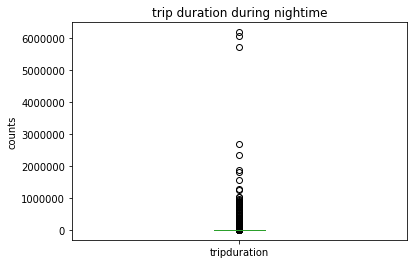

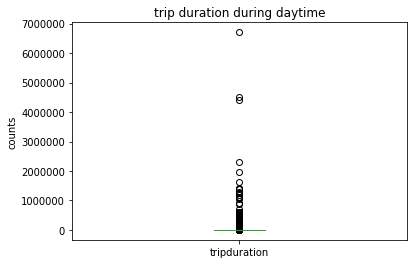

In [13]:



ax = nightriders.plot( y='tripduration',kind='box')
ax.set_ylabel('counts')
ax.set_title('trip duration during nightime')
ay = dayriders.plot( y='tripduration',kind='box')
ay.set_title('trip duration during daytime')
ay.set_ylabel('counts')

##### Fig 1: The spread of the tripduration values is large .The two boxplots are thus able to show only the outliers. Let us visualize the tripduration boxplot without the outliers

Text(0,0.5,'counts')

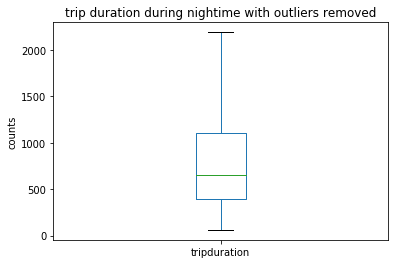

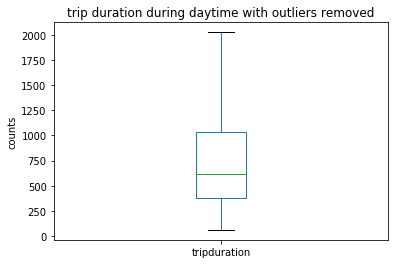

In [14]:
ax = nightriders.plot( y='tripduration',kind='box',showfliers=False)
ax.set_ylabel('counts')
ax.set_title('trip duration during nightime with outliers removed')
ay = dayriders.plot( y='tripduration',kind='box',showfliers=False)
ay.set_title('trip duration during daytime with outliers removed')
ay.set_ylabel('counts')

##### Fig 2: The boxplots here show where the bulk of the tripduration is clustered, which is mostly around 2500 seconds


#### For the purpose of plotting the histograms we will only be using tripdurations upto 10800 , ie 3 hours

Text(0.5,1,'Tripduration distribution of dayriders')

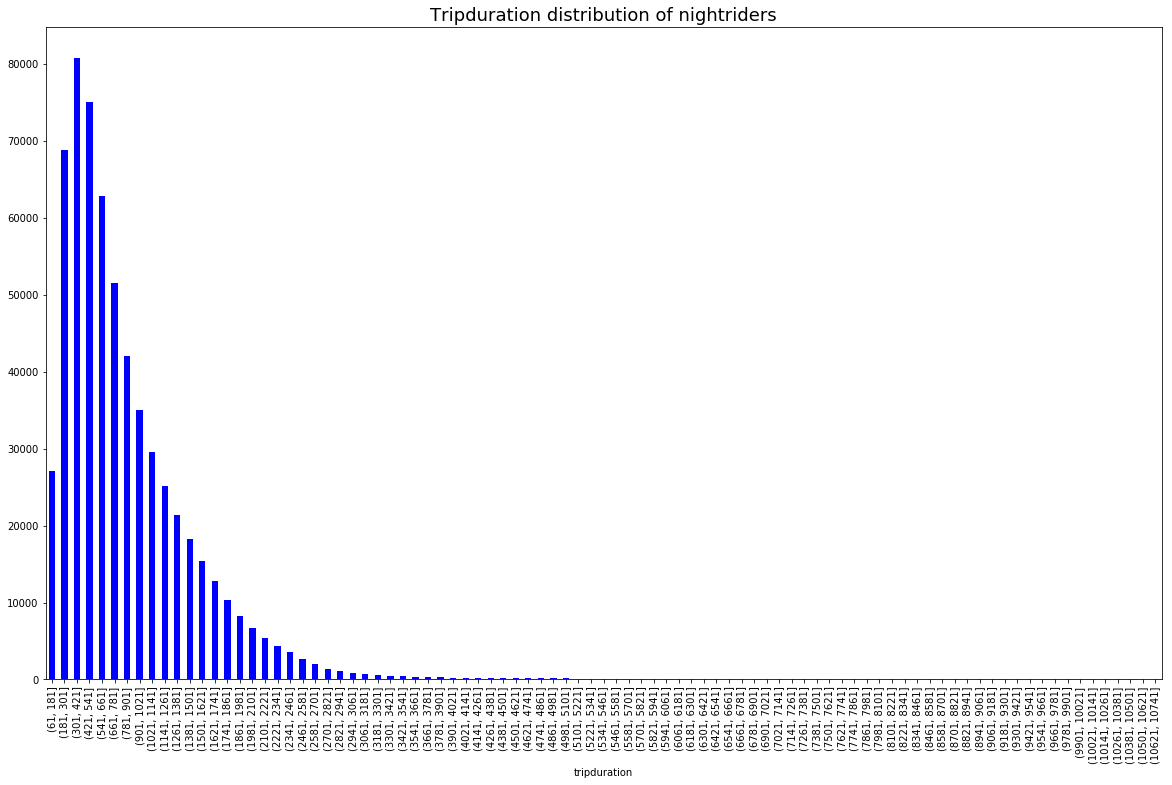

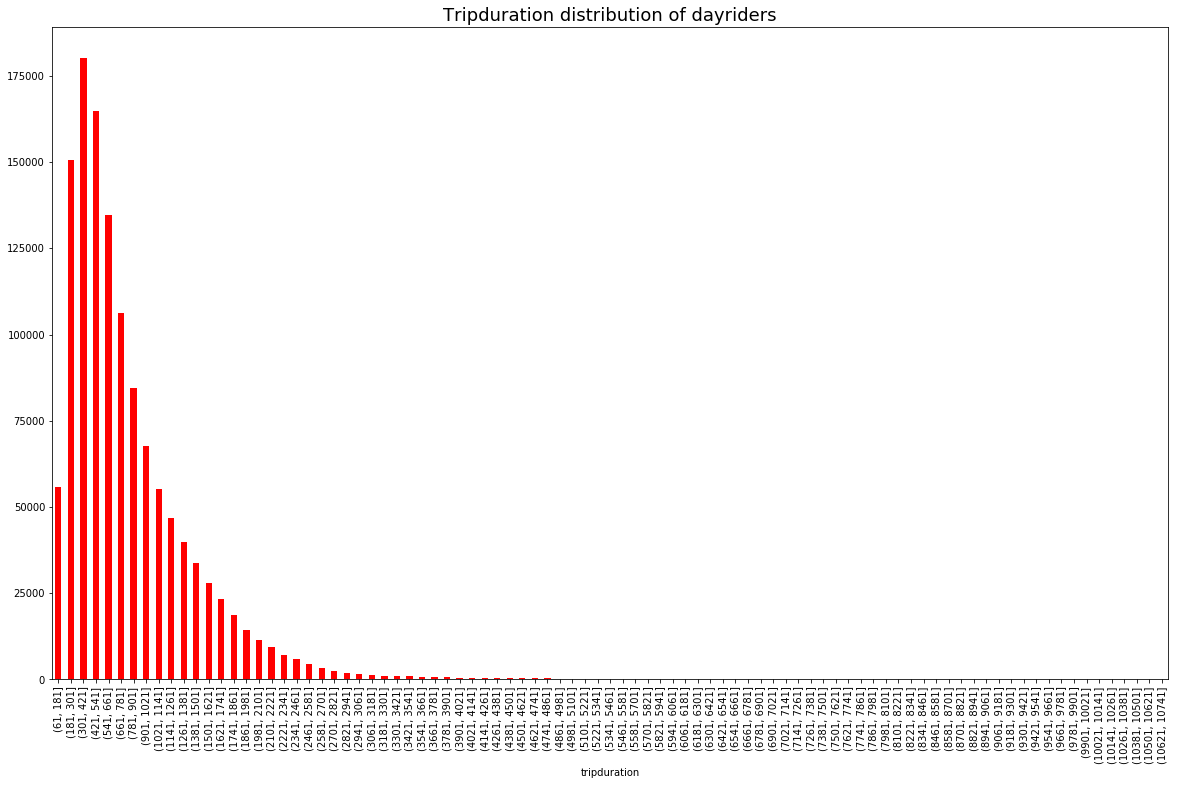

In [15]:
bins = np.arange(61,10800,120)
axNight = nightriders['tripduration'].groupby(pd.cut(nightriders['tripduration'],bins)).agg([count_nonzero]).plot(kind='bar',legend=False,figsize=(20,12),color='blue')
axNight.set_title('Tripduration distribution of nightriders',size='18')


axDay = dayriders['tripduration'].groupby(pd.cut(dayriders['tripduration'],bins)).agg([count_nonzero]).plot(kind='bar',legend=False,color='red',figsize=(20,12))
axDay.set_title('Tripduration distribution of dayriders',size='18')

** Fig 3: Trip duration distribution of day and night riders **

Both distributions look similar , but further testing is required to say it with certainity

# Normalizing the tripduration distributions

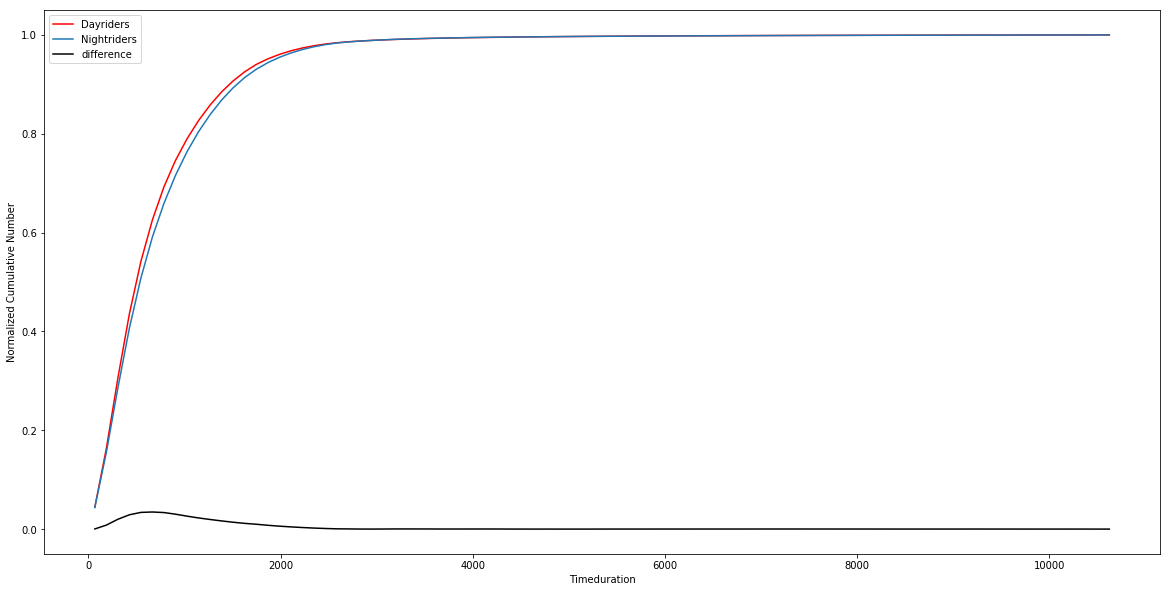

In [16]:
csDayriders = dayriders.tripduration.groupby(pd.cut(dayriders.tripduration,bins)).agg([count_nonzero]).cumsum()

csNightriders = nightriders.tripduration.groupby(pd.cut(nightriders.tripduration,bins)).agg([count_nonzero]).cumsum()


#print(np.abs(csDayriders /csDayriders.max() - csNightriders /csNightriders.max()))
pl.figure(figsize=(20,10))
pl.plot(bins[:-1]+5 ,csDayriders/csDayriders.max(),label='Dayriders',color='r',)
pl.plot(bins[:-1]+5 , csNightriders/csNightriders.max(),label='Nightriders')
pl.plot(bins[:-1]+5, np.abs(csDayriders /csDayriders.max() - csNightriders /csNightriders.max()), 'k',
        label = "difference")

pl.xlabel("Timeduration")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

#### Fig 4: The cumulative tripduration distribution of day and night riders.
Although there look similar, the difference gets to around  ~ 5%

# Null hypothesis for KS Test

## $H_0$ : The samples of the trip duration distribution of dayriders and night riders is the same, p= 0.05

##  $\alpha$ = 0.05

In [17]:
ks = scipy.stats.ks_2samp(pd.Series(dayriders['tripduration']), pd.Series(nightriders['tripduration']))
ks

Ks_2sampResult(statistic=0.035123365813344187, pvalue=0.0)

** Taking sample size 200 times smaller **

In [18]:
dayrider_sample = dayriders.sample(frac=0.005,random_state=13)

nightrider_sample = nightriders.sample(frac = 0.005, random_state=13)


In [19]:
ks_sample = scipy.stats.ks_2samp(pd.Series(dayrider_sample['tripduration']), pd.Series(nightrider_sample['tripduration']))
ks_sample

Ks_2sampResult(statistic=0.047853885804916785, pvalue=0.0001358652476690446)

#### Null Hypothesis testing for sample at alpha_level=0.05

In [20]:
def ks_null_test(m,n,c_alpha,KSstats):
    if (ks_sample.statistic > (c_alpha * np.sqrt((m + n )/(m*n)))):
        x = c_alpha * np.sqrt((m + n )/(m*n))
        print(x)
        print("Reject the null")
    
    else:
        print("Fail to reject the null")
    print("KS Statistic "+str(KSstats.statistic))
    print("KS Pvalue "+str(KSstats.pvalue))

In [21]:
c_alpha=1.36
m=dayrider_sample.size
n= nightrider_sample.size
ks_null_test(m,n,c_alpha,ks_sample)

0.0210645123435
Reject the null
KS Statistic 0.0478538858049
KS Pvalue 0.000135865247669


In [22]:
c_alpha=1.36
m=dayriders.size
n= nightriders.size
ks_null_test(m,n,c_alpha,ks)

0.00148947049955
Reject the null
KS Statistic 0.0351233658133
KS Pvalue 0.0


#### Based on the KS test, since the pvalue < 0.05 ( 0.0 < 0.05) for both cases, we reject the null hypothesis that the distributions of the dayriders and nightriders are the same

# Testing for Correlation

# Null Hypothesis:

## $H_0$ : There is no correlation between tripduration of dayriders and nightriders having the same start station id, p =0.05

##  $\alpha$ = 0.05

### 1.  Pearson's test for correlation

In [23]:
# Group by the same start station id
dayriders_stationid_mean = pd.DataFrame(dayriders.groupby(['start station id'])['tripduration'].mean())
nightriders_stationid_mean = pd.DataFrame(nightriders.groupby(['start station id'])['tripduration'].mean())
dayriders_stationid_mean.rename(columns={'tripduration' :'meanTripDurationDaytime'},inplace=True)
nightriders_stationid_mean.rename(columns={'tripduration' :'meanTripDurationNightime'},inplace=True)

In [24]:
result = pd.concat([dayriders_stationid_mean, nightriders_stationid_mean], axis=1, join='inner')


In [25]:

pearson_results = scipy.stats.pearsonr(result.meanTripDurationDaytime,result.meanTripDurationNightime)
print(pearson_results)

if (pearson_results[1] < 0.05) :
    print('Reject the null')
else:
    print('Fail to reject the null')

(0.41264227483747518, 9.8619093142765161e-22)
Reject the null


#### The p value indicates probability of an uncorrelated system producing datasets having the pearson correlation coefficient as least as high as the one generated from this dataset , provided the null hypothesis were true. 

#### Thus, the low p value indicates that the possibiity is very less

Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr


#### There is a positive correlation between tripduration of dayriders and nightriders. 

#### Therefore, we reject the null hypothesis that there is no correlation between the tripduration of dayriders and nightriders

## 2. Spearman's test for correlation

In [26]:
spearmans_result = scipy.stats.spearmanr(result.meanTripDurationDaytime,result.meanTripDurationNightime)
print(spearmans_result)

if (spearmans_result[1] < 0.05) :
    print('Reject the null')
else:
    print('Fail to reject the null')

SpearmanrResult(correlation=0.47125292059636031, pvalue=1.120841938925331e-28)
Reject the null


#### The p value indicates probability of an uncorrelated system producing datasets having the spearman's correlation coefficient as least as high as the one generated from this dataset,  provided the null hypothesis were true. 


#### There is a positive correlation between tripduration of dayriders and nightriders. 

#### The p value is lesser than the alpha value of 0.05 ; which means that we reject the null hypothesis.

#### And accept the hypothesis that the two variables are correlated

# Extra Credit

### Using an educated guess to map the latitudinal and longitudinal ranges to of Brooklyn and Manhattan respectivey

In [27]:
brooklyn = df_2016[['birth year', 'end station id']][(df_2016['start station latitude'] >=  40.570066) & 
                                   (df_2016['start station latitude'] <  40.698649) & 
                                   (df_2016['start station longitude'] >= -74.036647 )  & 
                                   (df_2016['start station longitude'] <= -73.924627)]

manhattan = df_2016[['birth year', 'end station id']][(df_2016['start station latitude'] >=  40.698649) & 
                                    (df_2016['start station latitude'] <=  40.861564) & 
                                    (df_2016['start station longitude'] >= -74.006837 ) & 
                                    (df_2016['start station longitude'] <= -73.992114)]


In [28]:
manhattan['birth year'] = 2016 - manhattan['birth year']



In [29]:
manhattan.rename(columns={'birth year' : 'age'} ,inplace=True)



In [30]:
manhattan.dropna(inplace=True)
manhattan.size

942226

In [31]:
brooklyn['birth year'] = 2016 - brooklyn['birth year']
brooklyn.rename(columns={'birth year' : 'age'} ,inplace=True)
brooklyn.dropna(inplace=True)


In [32]:
brooklyn.size

174950

Text(0.5,0,'Age bins')

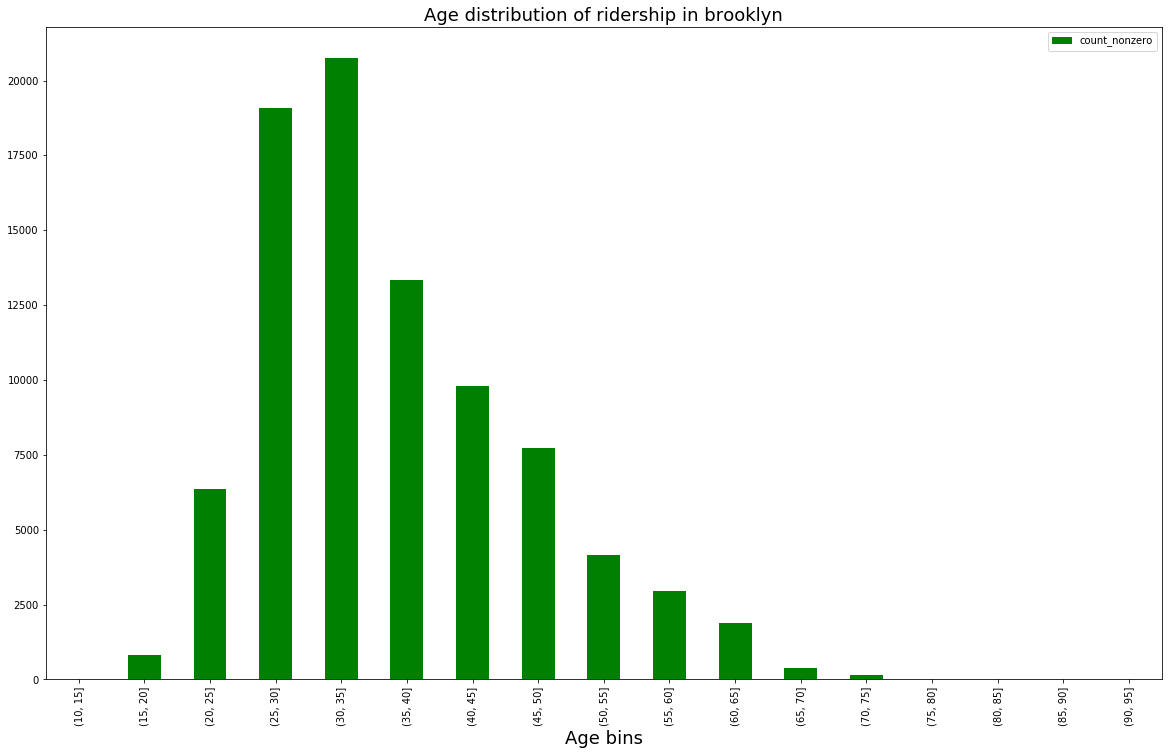

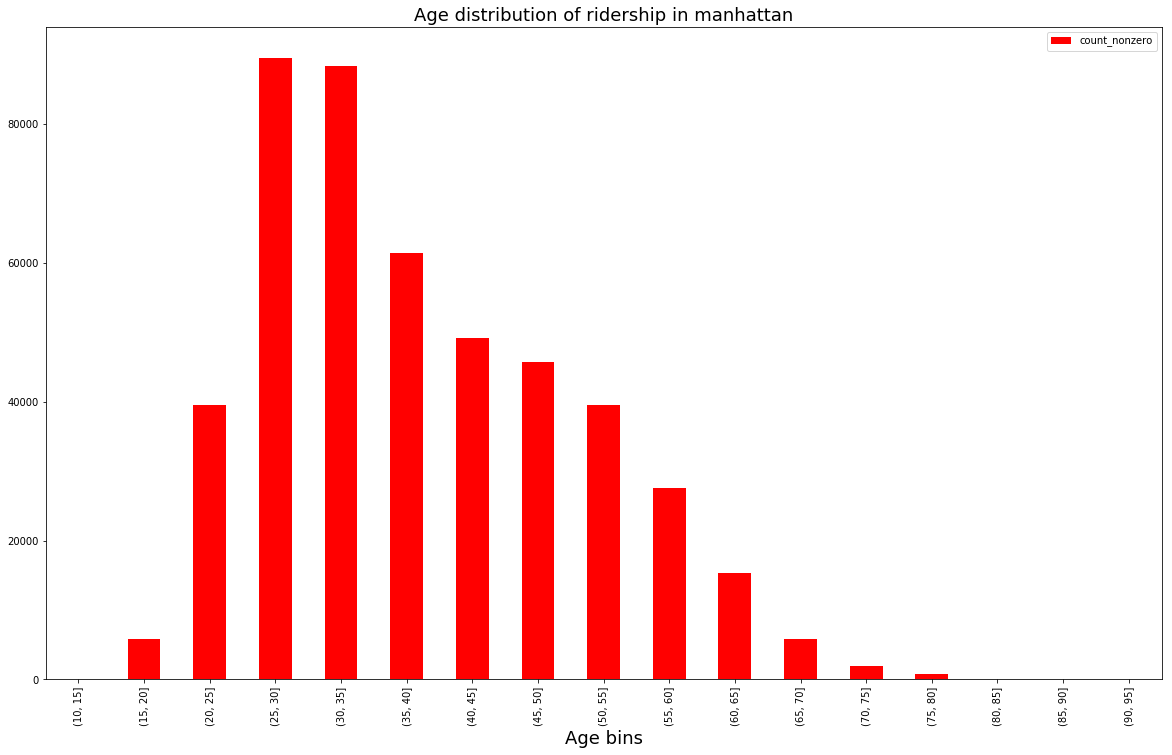

In [33]:
bins_age = np.arange(10,99,5)

axbrook = brooklyn.age.groupby(pd.cut(brooklyn.age,bins_age)).agg([count_nonzero]).plot(kind='bar',figsize=(20,12),legend='False',color='green')

axbrook.set_title('Age distribution of ridership in brooklyn', size='18')
axbrook.set_xlabel('Counts of age of ridership in brooklyn', size='18')
axbrook.set_xlabel('Age bins', size='18')
axmanhattan = manhattan.age.groupby(pd.cut(manhattan.age,bins_age)).agg([count_nonzero]).plot(kind='bar',figsize=(20,12),legend='False',color='red')

axmanhattan.set_title('Age distribution of ridership in manhattan', size='18')
axmanhattan.set_xlabel('Counts of age of ridership in manhattan', size='18')
axmanhattan.set_xlabel('Age bins', size='18')

##### Fig 5: Age distribution of riders in Manhattan and Brooklyn

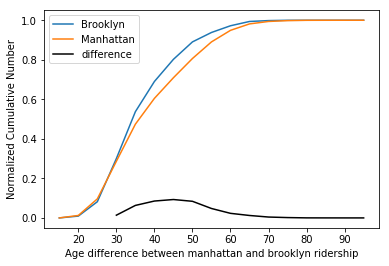

In [34]:
# Calculation of the cumulative sum

csBrooklyn = brooklyn.age.groupby(pd.cut(brooklyn.age,bins_age)).agg([count_nonzero]).cumsum()
csManhattan = manhattan.age.groupby(pd.cut(manhattan.age, bins_age)).agg([count_nonzero]).cumsum()


pl.plot(bins_age[:-1] + 5, csBrooklyn / csBrooklyn.max(), label = "Brooklyn")
pl.plot(bins_age[:-1] + 5, csManhattan / csManhattan.max(), label = "Manhattan")
pl.plot(bins_age[:-1] + 5, np.sqrt(csBrooklyn / csBrooklyn.max() - csManhattan / csManhattan.max())**2, 'k-',
        label = "difference")
pl.xlabel("Age difference between manhattan and brooklyn ridership")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

#### Fig 6: The cumulative distribution of age for riders in Manhattan and Brooklyn
There seems to be a pronounced difference oin ages of manhattan and brooklyn in the group 30 to 60

# Null hypothesis for KS Test

## $H_0$ : The samples of the age distribution for riders in Manhattan and Brooklyn is the same, p= 0.05

##  $\alpha$ = 0.05

In [35]:
ks_age = scipy.stats.ks_2samp(brooklyn.age,manhattan.age)
ks_age

Ks_2sampResult(statistic=0.094285585135546746, pvalue=0.0)

In [36]:
c_alpha=1.36
m=brooklyn.size
n= manhattan.size
ks_null_test(m,n,c_alpha,ks_age)

0.00354050483302
Reject the null
KS Statistic 0.0942855851355
KS Pvalue 0.0


In [37]:
brooklyn_sample = brooklyn.sample(frac=0.05 , random_state=13)
manhattan_sample = manhattan.sample(frac=0.05, random_state=13)

In [38]:
ks_sample_age = scipy.stats.ks_2samp(brooklyn_sample.age ,manhattan_sample.age )
ks_sample_age

Ks_2sampResult(statistic=0.10523200004845013, pvalue=4.7385205432360151e-36)

In [39]:
c_alpha=1.36
m=brooklyn_sample.size
n= manhattan_sample.size
ks_null_test(m,n,c_alpha,ks_sample_age)

0.0158332189046
Reject the null
KS Statistic 0.105232000048
KS Pvalue 4.73852054324e-36


#### Based on the KS test, since the pvalue < 0.05 for both cases, we reject the null hypothesis that the age distributions for riders in Manhattan and Brooklyn are the same

# Testing for Correlation

# Null Hypothesis:

## $H_0$ : There is no correlation between ages of riders of manhattan and brooklyn having the same end station id, p =0.05

##  $\alpha$ = 0.05

## 1. Pearson's test for correlation

#### Null Hypothesis: There is no correlation between ages of riders of manhattan and brooklyn having the same end station id

In [40]:
# Groupby the same endstation id

brooklyn_endstations_mean = pd.DataFrame(brooklyn.groupby(['end station id'])['age'].mean())
manhattan_endstations_mean = pd.DataFrame(manhattan.groupby(['end station id'])['age'].mean())

In [41]:
brooklyn_endstations_mean.rename(columns={'age' :'meanAgeBrooklyn'},inplace=True)
manhattan_endstations_mean.rename(columns={'age' :'meanAgeManhattan'},inplace=True)

In [42]:
result_age = pd.concat([brooklyn_endstations_mean,manhattan_endstations_mean], axis=1, join='inner')

In [43]:
pearsons_age_results = scipy.stats.pearsonr(result_age.meanAgeBrooklyn , result_age.meanAgeManhattan)
print(pearsons_age_results)

if (pearsons_age_results[1] < 0.05) :
    print('Reject the null')
else:
    print('Fail to reject the null')


(0.24731163364055703, 4.894381000953598e-08)
Reject the null


#### The p value indicates probability of an uncorrelated system producing datasets having the pearson correlation coefficient as least as high as the one generated from this dataset,  provided the null hypothesis were true. 

#### Thus, the low p value indicates that the possibiity is very less

Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr


#### There is a positive correlation between ages of riders of manhattan and brooklyn having the same end station id 

#### Therefore, we reject the null hypothesis that there is no correlation between ages of riders of manhattan and brooklyn having the same end station id 

# 2. Spearman's test for correlation

In [44]:
spearmans_result_age = scipy.stats.spearmanr(result_age.meanAgeBrooklyn,result_age.meanAgeManhattan)
print(spearmans_result_age)
if (spearmans_result_age[1] < 0.05) :
    print('Reject the null')
else:
    print('Fail to reject the null')


SpearmanrResult(correlation=0.38644821916405564, pvalue=2.4815722676354797e-18)
Reject the null


#### The p value indicates probability of an uncorrelated system producing datasets having the spearman correlation coefficient as least as high as the one generated from this dataset , provided the null hypothesis were true. 

#### Thus, the low p value indicates that the possibiity is very less



#### There is a positive correlation between ages of riders of manhattan and brooklyn having the same end station id 

#### Therefore, we reject the null hypothesis that there is no correlation between ages of riders of manhattan and brooklyn having the same end station id 